### This notebook contains Prophet, LightGBM, ARIMA, and EWA methods of M5 timeseries forecast 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_percentage_error

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download the CSV file
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
#All category items are grouped together to create a target variable

df.drop(columns=['item_id', 'dept_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['cat_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='cat_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_cat = data.groupby(level=0, axis=1).sum()

#All department items are grouped together to create a target variable

df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'cat_id','store_id','state_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['dept_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='dept_id',inplace=True) 
data.columns.name = None 

calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_dept = data.groupby(level=0, axis=1).sum()

#State-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','store_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['state_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='state_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_state = data.groupby(level=0, axis=1).sum()

#Store-wise categorization
df = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/sales_train_validation.csv')
df.drop(columns=['item_id', 'dept_id','state_id','cat_id'],axis=1, inplace=True) 
data = df.T
data.columns = df['store_id'] 
data.index.name = None   
data.drop(index='id',inplace=True) 
data.drop(index='store_id',inplace=True) 
data.columns.name = None 
 
calendar = pd.read_csv('C:/Users/Deepak/Desktop/Manuscript prep/calendar.csv')
data.index = calendar['date'][0:1913]
df_store = data.groupby(level=0, axis=1).sum()
#Concat all dataframes
df = pd.concat([df_cat,df_dept,df_state,df_store, ], axis=1)

df['ds'] = df.index.values
# Convert the 'ds' column to datetime type
df['ds'] = pd.to_datetime(df['ds'])
df.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,ds
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,3494,4739,1625,2556,3852,3030,2704,2256,4038,2011-01-29


### PROPHET MODEL

In [3]:
df_prophet = df.copy()

In [4]:
# Split the data into train and test sets

train_size = int(len(df_prophet) * 0.8)  # 80% for training
train, test = df_prophet[:train_size], df_prophet[train_size+1:]

In [5]:
#Create train and test dataframes for Prophet:
# train data has 2011-01-29 to 2015-04-07 (1530 rows) and test data has 2015-04-09 to 2016-04-24 (382 rows)
train_prophet = train.copy()
test_prophet = test.copy()
len(train_prophet),len(test_prophet)

(1530, 382)

In [6]:
target_columns = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
                  'HOUSEHOLD_2','CA','TX','WI','CA_1','CA_2','CA_3','CA_4','TX_1','TX_2','TX_3','WI_1','WI_2','WI_3']

In [7]:
#Prophet model with holidays

holidays = calendar[calendar['event_type_1'].isnull() == False]
holidays = holidays[['date','event_name_1', 'event_type_1']]
holidays.rename(columns={'date':'ds','event_name_1':'holiday'},inplace=True)

In [8]:
# Fit Prophet models for each target variable
models = {}
for column in target_columns:
    # Rename the columns to 'ds' and 'y'
    train_target = train_prophet[[column]].rename(columns={column: 'y'})
    train_target['ds'] = train_prophet.index
    
    model = Prophet(weekly_seasonality=True,holidays=holidays)
    model.fit(train_target)
    models[column] = model

14:11:54 - cmdstanpy - INFO - Chain [1] start processing
14:11:54 - cmdstanpy - INFO - Chain [1] done processing
14:11:54 - cmdstanpy - INFO - Chain [1] start processing
14:11:54 - cmdstanpy - INFO - Chain [1] done processing
14:11:55 - cmdstanpy - INFO - Chain [1] start processing
14:11:55 - cmdstanpy - INFO - Chain [1] done processing
14:11:55 - cmdstanpy - INFO - Chain [1] start processing
14:11:55 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:56 - cmdstanpy - INFO - Chain [1] done processing
14:11:56 - cmdstanpy - INFO - Chain [1] start processing
14:11:57 - cmdstanpy - INFO - Chain [1] done processing
14:11:57 - cmdstanpy - INFO - Chain [1] start processing
14:11:57 - cmdstanpy - INFO - Chain [1] done processing
14:11:57 - cmdstanpy - INFO - Chain [1] start processing
14:11:57 - cmdstanpy - INFO - Chain [1]

In [9]:
# Make predictions on the test set
predictions = {}
for column in target_columns:
    model = models[column]
    
    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test))
    
    # Rename the columns to 'ds'
    future = future.rename(columns={'ds': 'ds'})
    
    # Make predictions
    #The .tail(len(test))` part ensures that only the predictions for the test set are stored.
    forecast = model.predict(future)
    predictions[column] = forecast['yhat'].tail(len(test))

In [10]:
# Save predictions as predictions_prophet
predictions_prophet = predictions

# Print the values in predictions_prophet
for column, values in predictions_prophet.items():
    print(f"Predictions for {column}:")
    print(values)
    print()

Predictions for FOODS:
1530    21074.088280
1531    21165.591653
1532    23481.198484
1533    27412.350265
1534    27525.461058
            ...     
1907    19552.830867
1908    19199.858310
1909    19260.702342
1910    21552.431362
1911    26202.633758
Name: yhat, Length: 382, dtype: float64

Predictions for HOBBIES:
1530    3484.601887
1531    3523.271783
1532    3932.984138
1533    4715.141598
1534    3969.125216
           ...     
1907    3996.448235
1908    4001.578155
1909    4031.499113
1910    4433.560451
1911    5004.985772
Name: yhat, Length: 382, dtype: float64

Predictions for HOUSEHOLD:
1530     7876.436633
1531     7955.424689
1532     9025.088080
1533    10948.141079
1534     9890.238917
            ...     
1907     8941.749347
1908     8853.608270
1909     8929.737766
1910     9996.074575
1911    11746.538691
Name: yhat, Length: 382, dtype: float64

Predictions for FOODS_1:
1530    2699.896442
1531    2738.312241
1532    3013.627629
1533    3231.977243
1534    3252.75

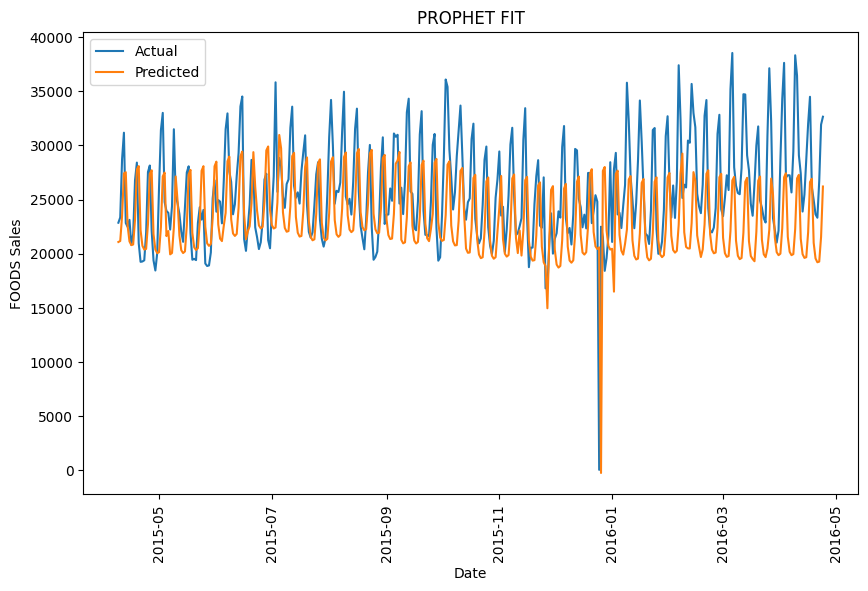

In [11]:
# Plot the predictions
# Convert the index to a DatetimeIndex

test.index = pd.to_datetime(test.index)

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['FOODS'], label='Actual')
plt.plot(test.index, predictions_prophet['FOODS'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('FOODS Sales')
plt.title('PROPHET FIT')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [13]:
mape_prophet = []
rmse_prophet = []

for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted = predictions[column].values
    mape = mean_absolute_percentage_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape_prophet.append(mape)
    rmse_prophet.append(rmse)

print("All RMSE values:", rmse_prophet)
print("All MAPE values:", mape_prophet)

All RMSE values: [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
All MAPE values: [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]


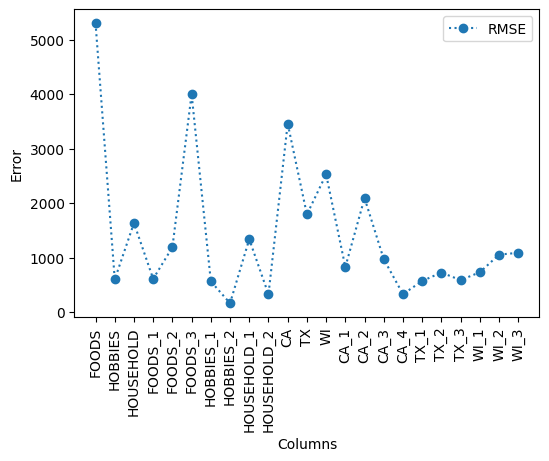

In [14]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_columns, rmse_prophet, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

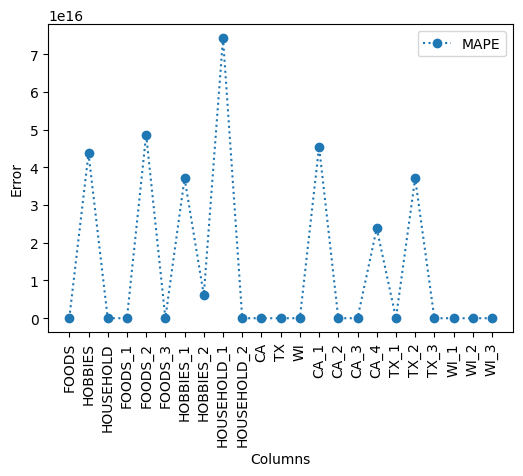

In [15]:
# Plot the MAPE values
plt.figure(figsize=(6, 4))
plt.plot(target_columns, mape_prophet, marker='o', linestyle='dotted', label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Error')
plt.legend()
plt.show()

### LightGBM

In [17]:
# For LightGBM, we donot need column 'ds'.
df_lgbm = df.drop(columns = ['ds'])
df_lgbm.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038


In [18]:
#Create lag_cols, lag by timestep 1 and backfill with the next immediate values to match dimensions.
#Lagged columns are lagged features or features for the data frame. 

lag_cols = ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3','HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA','TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3']
for col in lag_cols:
    df_lgbm[f'lag_1_{col}'] = df_lgbm[col].shift(1)

df_lgbm = df_lgbm.bfill()
df_lgbm.head(1)

,FOODS,HOBBIES,HOUSEHOLD,FOODS_1,FOODS_2,FOODS_3,HOBBIES_1,HOBBIES_2,HOUSEHOLD_1,HOUSEHOLD_2,...,lag_1_CA_1,lag_1_CA_2,lag_1_CA_3,lag_1_CA_4,lag_1_TX_1,lag_1_TX_2,lag_1_TX_3,lag_1_WI_1,lag_1_WI_2,lag_1_WI_3
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,23178,3764,5689,2343,4094,16741,3610,154,4105,1584,...,4337.0,3494.0,4739.0,1625.0,2556.0,3852.0,3030.0,2704.0,2256.0,4038.0


In [19]:
# Split the data into training and testing sets
train_size = int(len(df_lgbm) * 0.8)
train_data = df_lgbm[:train_size]
test_data = df_lgbm[train_size+1:]

# Now our target variables are the main data frame columns.
# We are labeling main target variables in dataframe as target variables if the difference in time by 1 step matches.

target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']  

feature_cols = [col for col in df_lgbm.columns if col not in target_cols]

train_dataset = lgb.Dataset(train_data[feature_cols], label=train_data[target_cols])
test_dataset = lgb.Dataset(test_data[feature_cols], label=test_data[target_cols])

In [20]:
# Since we have continous values, this problem is treated as regression. MSE is appropriate metric for regression. 
#`num_leaves --> represents the maximum number of leaves in a tree. A leaf is a node that does not have any child nodes. 
#A common practice is to set `num_leaves` to a value between 2^(max_depth) and 2^(max_depth+1)
# Maximum no. of levels is max_depth. Reduce no. of leaves for better accuracy.

params = {
    'objective': 'regression',
    'metric': 'mse',
    'learning_rate': 0.1,
    'num_leaves': 20,
    'max_depth': -1
}


In [21]:
models = {}  # Dictionary to store the trained models
rmse_lgbm = {}  # Dictionary to store the RMSE values
mape_lgbm = {} # Dictionary to store the MAPE values

# Train separate models for each target variable

for target_col in target_cols:
    train_label = train_data[target_col]
    test_label = test_data[target_col]

    train_dataset = lgb.Dataset(train_data[feature_cols], label=train_label)
    test_dataset = lgb.Dataset(test_data[feature_cols], label=test_label)

    # Train the model
    model = lgb.train(params, train_dataset, num_boost_round=100)
    models[target_col] = model

    # Evaluate the model
    predictions_lgbm = model.predict(test_data[feature_cols])
    mse = np.mean((predictions_lgbm - test_label) ** 2)
    rmse = math.sqrt(mse)
    rmse_lgbm[target_col] = rmse
    mape = mean_absolute_percentage_error(predictions_lgbm, test_label)
    mape_lgbm[target_col] = mape
    
    print("RMSE for {}: {}".format(target_col, rmse))
    print("MAPE for {}: {}".format(target_col, mape))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 23018.371895
RMSE for FOODS: 3323.572590710736
MAPE for FOODS: 0.09103209396153308
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 3031.590196
RMSE for HOBBIES: 584.9666530532597
MAPE for HOBBIES: 0.11834419501970976
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhe

RMSE for TX_3: 508.4821113023423
MAPE for TX_3: 0.10206807502411998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 2469.333333
RMSE for WI_1: 742.418801286614
MAPE for WI_1: 0.16312508129842623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 23
[LightGBM] [Info] Start training from score 3163.579739
RMSE for WI_2: 843.6342349679933
MAPE for WI_2: 0.14963717949499108
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 secon

In [22]:
predictions_lgbm = {}

for target_col in target_cols:
    model = models[target_col]
    
    # Get predictions for the target variable
    predictions_lgbm[target_col] = model.predict(test_data[feature_cols])
    
    # Print the predictions for the target variable
    print("Predictions for {}: {}".format(target_col, predictions_lgbm[target_col]))

Predictions for FOODS: [22617.57957559 22361.41136947 24526.30643063 27537.39640784
 28030.45097398 22300.42382139 26256.00225919 25076.63780814
 23661.07272899 24564.8733847  27228.44963341 25376.39050804
 20430.58119594 19912.16877069 20325.74442794 20214.30648848
 26499.86047442 29503.94269615 26942.42984041 22832.4090583
 18780.86229462 20278.05929566 19727.63260098 29116.27388114
 30338.07540538 29032.84145345 23031.68480782 23927.0138896
 23683.62075882 22149.7587471  28188.76904008 29012.51558846
 22675.73760582 23543.50182539 23293.93649883 23158.60182958
 23234.88916128 29063.581579   26596.66105599 28093.53012993
 22042.99446431 21272.66212727 20538.48704373 21497.65367075
 24155.73021129 26429.43693361 23892.17542548 23294.23564321
 19586.33203613 21261.85563714 20364.60545703 25159.0562035
 29088.51564609 24550.18261256 25132.36643547 25782.01111843
 25726.78403275 24976.58554371 27689.19290338 30178.46865337
 29676.39970186 26727.420726   25446.83092024 25794.14233314
 277

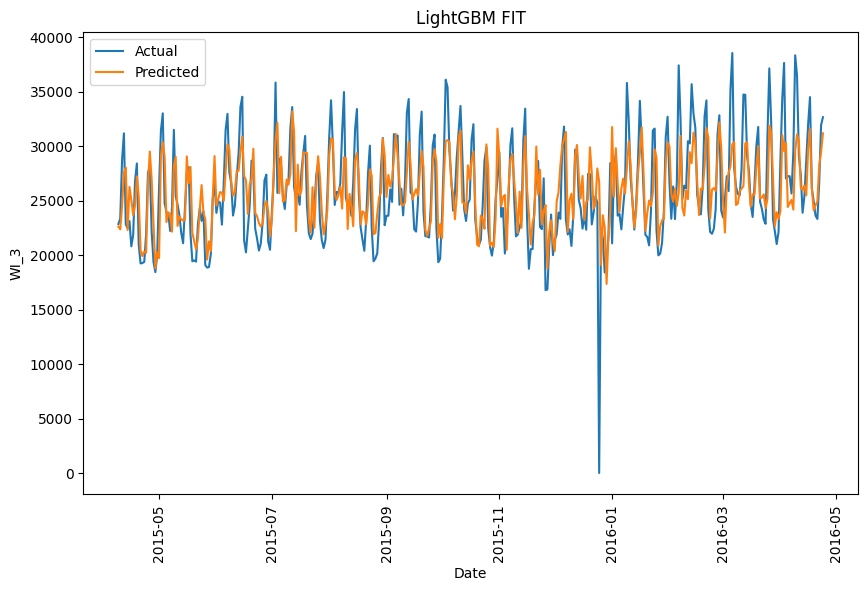

In [23]:
# Plot the predictions and test data
# Convert the index to a DatetimeIndex
test_data.index = pd.to_datetime(test_data.index)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data['FOODS'], label='Actual')
plt.plot(test_data.index, predictions_lgbm['FOODS'], label='Predicted')
plt.xlabel('Date')
plt.ylabel(target_col)
plt.title('LightGBM FIT')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [24]:
print("All RMSE values:", rmse_lgbm, "\n""\n""All MAPE values:", mape_lgbm)

All RMSE values: {'FOODS': 3323.572590710736, 'HOBBIES': 584.9666530532597, 'HOUSEHOLD': 1556.9815601826692, 'FOODS_1': 433.580811885487, 'FOODS_2': 985.145058307548, 'FOODS_3': 2506.319096949099, 'HOBBIES_1': 546.4696275758293, 'HOBBIES_2': 74.11445759725457, 'HOUSEHOLD_1': 1270.9895115013646, 'HOUSEHOLD_2': 304.84942938691574, 'CA': 2524.9280791791202, 'TX': 1345.9826239889562, 'WI': 1989.1700887986544, 'CA_1': 711.5579674482576, 'CA_2': 1228.992715257973, 'CA_3': 795.5612385655091, 'CA_4': 267.6572116193387, 'TX_1': 452.17616746632797, 'TX_2': 595.6935014294424, 'TX_3': 508.4821113023423, 'WI_1': 742.418801286614, 'WI_2': 843.6342349679933, 'WI_3': 632.6615970831949} 

All MAPE values: {'FOODS': 0.09103209396153308, 'HOBBIES': 0.11834419501970976, 'HOUSEHOLD': 0.12334029634086478, 'FOODS_1': 0.10585752692541775, 'FOODS_2': 0.1526492489023425, 'FOODS_3': 0.10068463661244745, 'HOBBIES_1': 0.1250662873532851, 'HOBBIES_2': 0.15851564777142907, 'HOUSEHOLD_1': 0.12784034943337377, 'HOUSEH

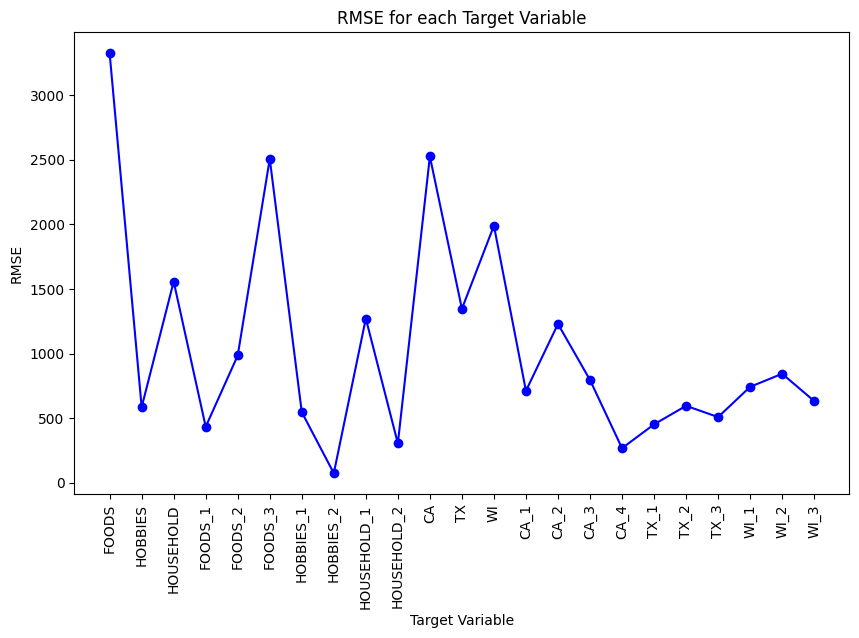

In [25]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(rmse_lgbm.keys()), list(rmse_lgbm.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('RMSE')
plt.title('RMSE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

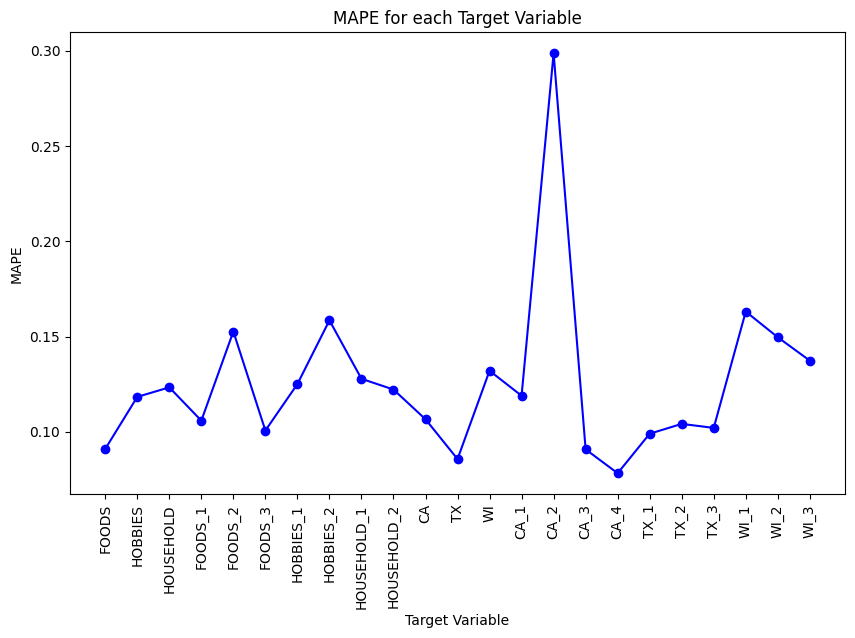

In [26]:
# Plot RMSE values against each target variable
plt.figure(figsize=(10, 6))
plt.plot(list(mape_lgbm.keys()), list(mape_lgbm.values()), marker='o', linestyle='-', color='blue')
plt.xlabel('Target Variable')
plt.ylabel('MAPE')
plt.title('MAPE for each Target Variable')
plt.xticks(rotation=90)
plt.show()

### ARIMA model (SARIMA)

In [28]:
#Create data frame for ARIMA:
df_arima = df.copy()

# train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
# Split the data into train and test sets
train_size = int(len(df_arima) * 0.8)  # 80% for training
train, test = df_arima[:train_size], df_arima[train_size+1:]

In [29]:
target_columns = ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3','HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA','TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3']

results = {}

for column in target_columns:
    train_target = train[column]
    model = pm.auto_arima(train_target, seasonal=True, m=12, suppress_warnings=True)

    p, d, q = model.order
    P, D, Q, m = model.seasonal_order

    # Print the estimated parameters
    print(f"Estimated parameters for {column}: p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}, m={m}")
    
    forecast = model.predict(n_periods=len(test))
    rmse = np.sqrt(mean_squared_error(test[column], forecast))
    mape = mean_absolute_percentage_error(test[column], forecast)
    
    #results dictionary will store all values.
    
    results[column] = {'order': model.order, 'seasonal_order': model.seasonal_order, 'RMSE': rmse, 'MAPE': mape}

Estimated parameters for FOODS: p=5, d=1, q=5, P=2, D=0, Q=1, m=12
Estimated parameters for HOBBIES: p=5, d=1, q=2, P=0, D=0, Q=1, m=12
Estimated parameters for HOUSEHOLD: p=5, d=1, q=5, P=1, D=0, Q=0, m=12
Estimated parameters for FOODS_1: p=4, d=1, q=3, P=1, D=0, Q=0, m=12
Estimated parameters for FOODS_2: p=4, d=1, q=5, P=0, D=0, Q=0, m=12
Estimated parameters for FOODS_3: p=5, d=1, q=5, P=1, D=0, Q=2, m=12
Estimated parameters for HOBBIES_1: p=5, d=1, q=5, P=0, D=0, Q=2, m=12
Estimated parameters for HOBBIES_2: p=0, d=1, q=2, P=0, D=0, Q=1, m=12
Estimated parameters for HOUSEHOLD_1: p=2, d=1, q=5, P=2, D=0, Q=1, m=12
Estimated parameters for HOUSEHOLD_2: p=5, d=1, q=2, P=0, D=0, Q=0, m=12
Estimated parameters for CA: p=5, d=1, q=2, P=1, D=0, Q=0, m=12
Estimated parameters for TX: p=3, d=1, q=3, P=1, D=0, Q=1, m=12
Estimated parameters for WI: p=0, d=1, q=3, P=1, D=0, Q=2, m=12
Estimated parameters for CA_1: p=4, d=1, q=5, P=0, D=0, Q=0, m=12
Estimated parameters for CA_2: p=2, d=1,

In [63]:
results['FOODS']

{'order': (5, 1, 5),
 'seasonal_order': (2, 0, 1, 12),
 'RMSE': 4414.427801036455,
 'MAPE': 4.552398391956181}

In [30]:
# Fit ARIMA 
model = ARIMA(test['FOODS'], order=(5,1,5), seasonal_order=(2,0,1,12))
model_fit = model.fit()

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [78]:
arima_models = {}

for column in target_columns:
    if column in results:
        params = results[column]
        if 'order' in params and 'seasonal_order' in params:
            order = params['order']
            seasonal_order = params['seasonal_order']

            model = ARIMA(test[column], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()

            arima_models[column] = model_fit

            print(f"ARIMA Model Fit for {column}:")
            print(model_fit.summary())
        else:
            print(f"No order or seasonal_order found for column: {column}")
    else:
        print(f"No results found for column: {column}")

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\

ARIMA Model Fit for FOODS:
                                     SARIMAX Results                                      
Dep. Variable:                              FOODS   No. Observations:                  382
Model:             ARIMA(5, 1, 5)x(2, 0, [1], 12)   Log Likelihood               -3567.430
Date:                            Sun, 23 Jul 2023   AIC                           7162.859
Time:                                    16:47:10   BIC                           7218.058
Sample:                                04-09-2015   HQIC                          7184.760
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3562      0.089     15.234      0.000       1.182       1.531
ar.L2   

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for HOBBIES:
                                     SARIMAX Results                                      
Dep. Variable:                            HOBBIES   No. Observations:                  382
Model:             ARIMA(5, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -2866.510
Date:                            Sun, 23 Jul 2023   AIC                           5751.021
Time:                                    16:47:11   BIC                           5786.506
Sample:                                04-09-2015   HQIC                          5765.100
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4181      0.042     10.055      0.000       0.337       0.500
ar.L2 

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for HOUSEHOLD:
                                     SARIMAX Results                                     
Dep. Variable:                         HOUSEHOLD   No. Observations:                  382
Model:             ARIMA(5, 1, 5)x(1, 0, [], 12)   Log Likelihood               -3177.439
Date:                           Sun, 23 Jul 2023   AIC                           6378.879
Time:                                   16:47:12   BIC                           6426.192
Sample:                               04-09-2015   HQIC                          6397.651
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1763      0.067     17.477      0.000       1.044       1.308
ar.L2       

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for FOODS_1:
                                     SARIMAX Results                                     
Dep. Variable:                           FOODS_1   No. Observations:                  382
Model:             ARIMA(4, 1, 3)x(1, 0, [], 12)   Log Likelihood               -2815.516
Date:                           Sun, 23 Jul 2023   AIC                           5649.032
Time:                                   16:47:13   BIC                           5684.518
Sample:                               04-09-2015   HQIC                          5663.112
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7184      0.050     34.672      0.000       1.621       1.816
ar.L2         

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for FOODS_2:
                               SARIMAX Results                                
Dep. Variable:                FOODS_2   No. Observations:                  382
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -3004.898
Date:                Sun, 23 Jul 2023   AIC                           6029.796
Time:                        16:47:13   BIC                           6069.224
Sample:                    04-09-2015   HQIC                          6045.439
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7989      0.013     63.325      0.000       0.774       0.824
ar.L2         -1.4337      0.019    -76.232      0.000      -1.471      -1.397
ar.L3          0.7844  

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for FOODS_3:
                                       SARIMAX Results                                       
Dep. Variable:                               FOODS_3   No. Observations:                  382
Model:             ARIMA(5, 1, 5)x(1, 0, [1, 2], 12)   Log Likelihood               -3428.664
Date:                               Sun, 23 Jul 2023   AIC                           6885.328
Time:                                       16:47:16   BIC                           6940.528
Sample:                                   04-09-2015   HQIC                          6907.229
                                        - 04-24-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3091      0.075     17.455      0.000       

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for HOBBIES_1:
                                       SARIMAX Results                                       
Dep. Variable:                             HOBBIES_1   No. Observations:                  382
Model:             ARIMA(5, 1, 5)x(0, 0, [1, 2], 12)   Log Likelihood               -2801.631
Date:                               Sun, 23 Jul 2023   AIC                           5629.263
Time:                                       16:47:19   BIC                           5680.519
Sample:                                   04-09-2015   HQIC                          5649.600
                                        - 04-24-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9443      0.087     10.894      0.000     

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\sta

ARIMA Model Fit for HOUSEHOLD_1:
                                     SARIMAX Results                                      
Dep. Variable:                        HOUSEHOLD_1   No. Observations:                  382
Model:             ARIMA(2, 1, 5)x(2, 0, [1], 12)   Log Likelihood               -3178.523
Date:                            Sun, 23 Jul 2023   AIC                           6379.046
Time:                                    16:47:21   BIC                           6422.416
Sample:                                04-09-2015   HQIC                          6396.254
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4407      0.010    -45.713      0.000      -0.460      -0.422
ar

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\

ARIMA Model Fit for CA:
                                     SARIMAX Results                                     
Dep. Variable:                                CA   No. Observations:                  382
Model:             ARIMA(5, 1, 2)x(1, 0, [], 12)   Log Likelihood               -3412.046
Date:                           Sun, 23 Jul 2023   AIC                           6842.093
Time:                                   16:47:22   BIC                           6877.578
Sample:                               04-09-2015   HQIC                          6856.172
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2330      0.057      4.069      0.000       0.121       0.345
ar.L2         -0.69

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for TX:
                                     SARIMAX Results                                      
Dep. Variable:                                 TX   No. Observations:                  382
Model:             ARIMA(3, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -3274.381
Date:                            Sun, 23 Jul 2023   AIC                           6566.762
Time:                                    16:47:23   BIC                           6602.248
Sample:                                04-09-2015   HQIC                          6580.842
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4463      0.052     27.778      0.000       1.344       1.548
ar.L2      

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for WI:
                                       SARIMAX Results                                       
Dep. Variable:                                    WI   No. Observations:                  382
Model:             ARIMA(0, 1, 3)x(1, 0, [1, 2], 12)   Log Likelihood               -3401.987
Date:                               Sun, 23 Jul 2023   AIC                           6817.975
Time:                                       16:47:25   BIC                           6845.574
Sample:                                   04-09-2015   HQIC                          6828.925
                                        - 04-24-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4564      0.043    -10.723      0.000      -0.540

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\

ARIMA Model Fit for CA_1:
                               SARIMAX Results                                
Dep. Variable:                   CA_1   No. Observations:                  382
Model:                 ARIMA(4, 1, 5)   Log Likelihood               -2918.096
Date:                Sun, 23 Jul 2023   AIC                           5856.193
Time:                        16:47:25   BIC                           5895.621
Sample:                    04-09-2015   HQIC                          5871.836
                         - 04-24-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8019      0.027     29.213      0.000       0.748       0.856
ar.L2         -1.4226      0.041    -35.115      0.000      -1.502      -1.343
ar.L3          0.7756     

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for CA_2:
                                     SARIMAX Results                                      
Dep. Variable:                               CA_2   No. Observations:                  382
Model:             ARIMA(2, 1, 3)x(2, 0, [1], 12)   Log Likelihood               -3014.866
Date:                            Sun, 23 Jul 2023   AIC                           6047.732
Time:                                    16:47:27   BIC                           6083.217
Sample:                                04-09-2015   HQIC                          6061.812
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2453      0.006    196.123      0.000       1.233       1.258
ar.L2    

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for CA_3:
                                       SARIMAX Results                                       
Dep. Variable:                                  CA_3   No. Observations:                  382
Model:             ARIMA(5, 1, 3)x(2, 0, [1, 2], 12)   Log Likelihood               -3022.519
Date:                               Sun, 23 Jul 2023   AIC                           6071.038
Time:                                       16:47:29   BIC                           6122.295
Sample:                                   04-09-2015   HQIC                          6091.375
                                        - 04-24-2016                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2964      0.168      7.728      0.000       0.9

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\

ARIMA Model Fit for CA_4:
                                     SARIMAX Results                                      
Dep. Variable:                               CA_4   No. Observations:                  382
Model:             ARIMA(4, 1, 3)x(1, 0, [1], 12)   Log Likelihood               -2620.632
Date:                            Sun, 23 Jul 2023   AIC                           5261.263
Time:                                    16:47:30   BIC                           5300.691
Sample:                                04-09-2015   HQIC                          5276.907
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4132      0.077     18.307      0.000       1.262       1.565
ar.L2    

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA Model Fit for TX_1:
                                     SARIMAX Results                                      
Dep. Variable:                               TX_1   No. Observations:                  382
Model:             ARIMA(5, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -2816.067
Date:                            Sun, 23 Jul 2023   AIC                           5654.134
Time:                                    16:47:32   BIC                           5697.505
Sample:                                04-09-2015   HQIC                          5671.342
                                     - 04-24-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2039      0.062      3.294      0.001       0.083       0.325
ar.L2    

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\

ARIMA Model Fit for TX_2:
                                    SARIMAX Results                                     
Dep. Variable:                             TX_2   No. Observations:                  382
Model:             ARIMA(3, 1, 1)x(2, 0, 1, 12)   Log Likelihood               -2952.806
Date:                          Sun, 23 Jul 2023   AIC                           5921.613
Time:                                  16:47:34   BIC                           5953.155
Sample:                              04-09-2015   HQIC                          5934.128
                                   - 04-24-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3261      0.038      8.492      0.000       0.251       0.401
ar.L2         -0.1288    

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\

ARIMA Model Fit for WI_1:
                                    SARIMAX Results                                     
Dep. Variable:                             WI_1   No. Observations:                  382
Model:             ARIMA(5, 1, 2)x(0, 0, 2, 12)   Log Likelihood               -2949.804
Date:                          Sun, 23 Jul 2023   AIC                           5919.609
Time:                                  16:47:36   BIC                           5959.037
Sample:                              04-09-2015   HQIC                          5935.252
                                   - 04-24-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0663      0.129      0.516      0.606      -0.186       0.318
ar.L2         -0.3850    

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\

ARIMA Model Fit for WI_2:
                                     SARIMAX Results                                     
Dep. Variable:                              WI_2   No. Observations:                  382
Model:             ARIMA(5, 1, 5)x(1, 0, [], 12)   Log Likelihood               -3026.025
Date:                           Sun, 23 Jul 2023   AIC                           6076.049
Time:                                   16:47:37   BIC                           6123.363
Sample:                               04-09-2015   HQIC                          6094.821
                                    - 04-24-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4059      0.179     -2.264      0.024      -0.757      -0.054
ar.L2         -0.

In [31]:
# Generate predictions using the fitted model
predictions_arima = model_fit.predict(start=1, end=len(test['FOODS']), typ='levels')
predictions_arima

C:\Users\Deepak\miniconda3\envs\NNExperiments\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


2015-04-10    20436.497926
2015-04-11    19164.541864
2015-04-12    24567.223944
2015-04-13    24466.028992
2015-04-14    16364.637609
                  ...     
2016-04-21    23441.641953
2016-04-22    26830.537903
2016-04-23    32775.706691
2016-04-24    32539.071176
2016-04-25    27786.716033
Freq: D, Name: predicted_mean, Length: 382, dtype: float64

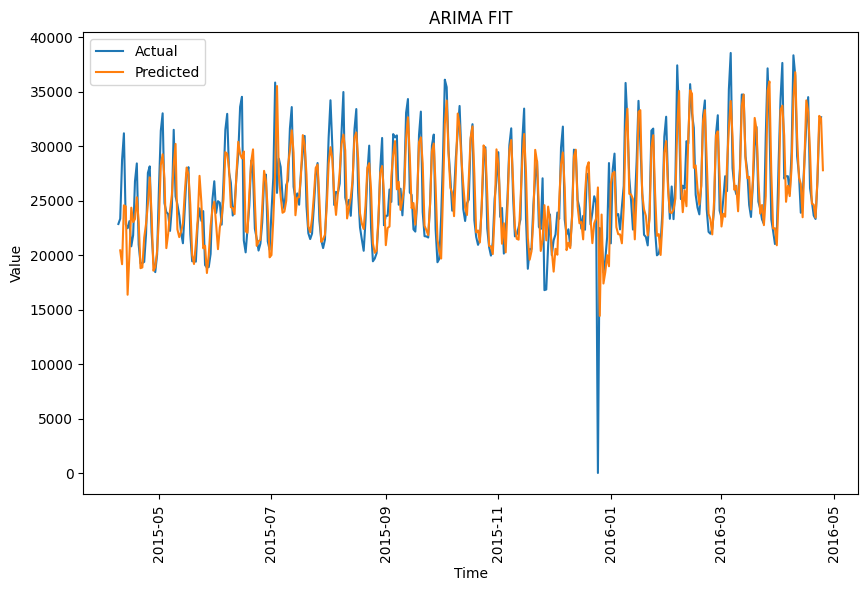

In [32]:
# Convert the index to a DatetimeIndex
test.index = pd.to_datetime(test.index)
plt.figure(figsize=(10, 6))

# Plot the actual and predicted values for the "FOODS" category
plt.plot(test['FOODS'], label='Actual')
plt.plot(predictions_arima, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('ARIMA FIT')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [33]:
rmse_values = []
mape_values = []
target_variables = []

for column, result in results.items():
    target_variables.append(column)
    rmse_values.append(result['RMSE'])
    mape_values.append(result['MAPE'])

print("Target Variables:", target_variables, "\n","\n", "RMSE Values:", rmse_values, "\n", "\n","MAPE Values:", mape_values)

Target Variables: ['FOODS', 'HOBBIES', 'HOUSEHOLD', 'FOODS_1', 'FOODS_2', 'FOODS_3', 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'CA', 'TX', 'WI', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'] 
 
 RMSE Values: [4414.427801036455, 625.0129703702443, 1708.9953500272914, 487.1101013596283, 1062.1228870227712, 3053.347541667216, 555.4494543218098, 107.7151437045555, 1805.211932364774, 314.772886635246, 2845.1658686836577, 2455.6378820617315, 2568.189448239621, 796.0200794610948, 1679.6588711859101, 1089.7251686454244, 714.4705377660863, 624.2840181834466, 983.8099082992557, 582.2712860138937, 765.2309697498303, 1090.065208980127, 853.7038134989234] 
 
 MAPE Values: [4.552398391956181, 4.909902140005632e+16, 21.267312736323365, 8.06251557292648, 5.223556724520484e+16, 3.6430120788858784, 4.140351401850404e+16, 4706108864513807.0, 1.0229238476963355e+17, 5.02294043021412, 6.609414302589637, 8.242927970195646, 6.970185839792852, 4.7063467144308776

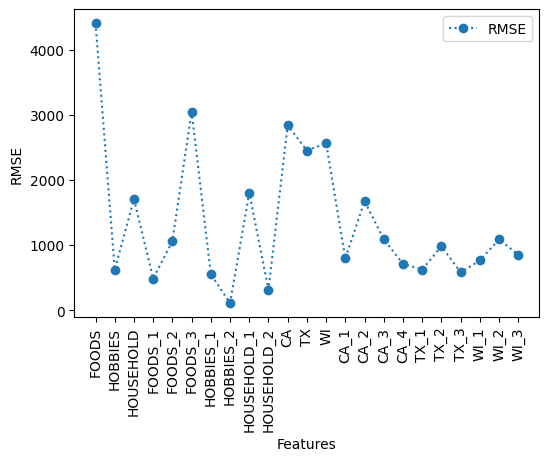

In [37]:
# Plot the RMSE values
plt.figure(figsize=(6,4))
plt.plot(target_variables, rmse_values, marker='o', linestyle='dotted', label='RMSE')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('RMSE')
plt.legend()
plt.show()

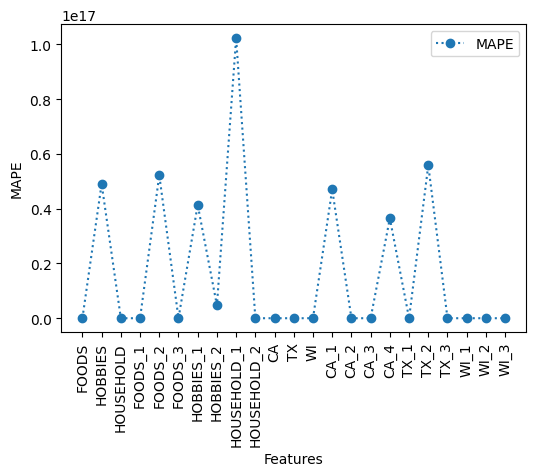

In [38]:
# Plot the MAPE values
plt.figure(figsize=(6,4))
plt.plot(target_variables, mape_values, marker='o', linestyle='dotted',label='MAPE')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('MAPE')
#plt.title('MAPE')
plt.legend()
plt.show()

### RMSE plots

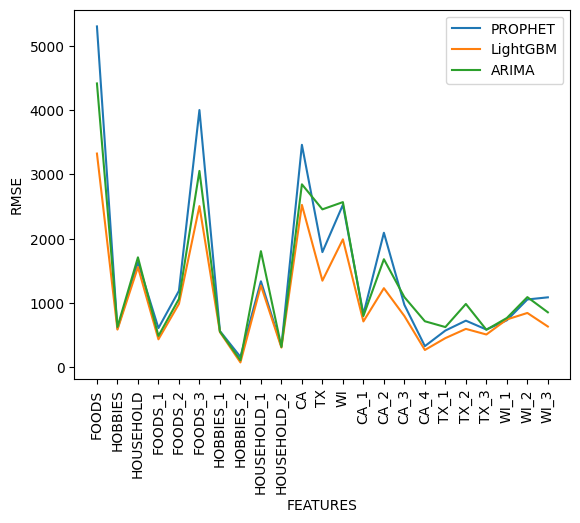

In [39]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']

prophet_rmse = [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
lgbm_rmse = [3323.572590710736, 584.9666530532597, 1556.9815601826692, 433.580811885487, 985.145058307548, 2506.319096949099, 546.4696275758293, 74.11445759725457,1270.9895115013646, 304.84942938691574, 2524.9280791791202, 1345.9826239889562, 1989.1700887986544, 711.5579674482576, 1228.992715257973, 795.5612385655091, 267.6572116193387, 452.17616746632797, 595.6935014294424, 508.4821113023423, 742.418801286614, 843.6342349679933, 632.6615970831949]
arima_rmse = [4414.427801036455, 625.0129703702443, 1708.9953500272914, 487.1101013596283, 1062.1228870227712, 3053.347541667216, 555.4494543218098, 107.7151437045555, 1805.211932364774, 314.772886635246, 2845.1658686836577, 2455.6378820617315, 2568.189448239621, 796.0200794610948, 1679.6588711859101, 1089.7251686454244, 714.4705377660863, 624.2840181834466, 983.8099082992557, 582.2712860138937, 765.2309697498303, 1090.065208980127, 853.7038134989234] 


plt.plot(target_cols, prophet_rmse, label="PROPHET")
plt.plot(target_cols, lgbm_rmse, label="LightGBM")
plt.plot(target_cols, arima_rmse, label="ARIMA")
plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### MAPE plots

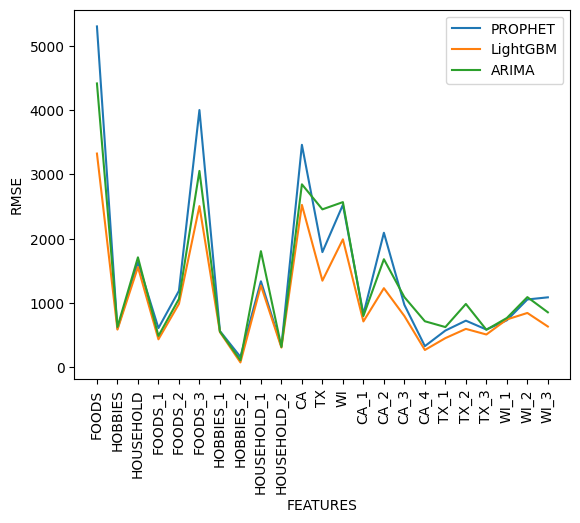

In [40]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3'] 
prophet_mape = [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]
lgbm_mape = [0.09103209396153308,0.11834419501970976, 0.12334029634086478, 0.10585752692541775, 0.1526492489023425, 0.10068463661244745, 0.1250662873532851,0.15851564777142907,0.12784034943337377, 0.12220433124696857, 0.10660274724359552, 0.0856975029548464, 0.13205575167781078,0.11893808321323282, 0.29872346641541914, 0.09078957270617109, 0.07827491405723837, 0.09900575265306356, 0.10417071978561113, 0.10206807502411998, 0.16312508129842623, 0.14963717949499108, 0.13737085799497573]
arima_mape = [4.552398391956181, 4.909902140005632e+16, 21.267312736323365, 8.06251557292648, 5.223556724520484e+16, 3.6430120788858784, 4.140351401850404e+16, 4706108864513807.0, 1.0229238476963355e+17, 5.02294043021412, 6.609414302589637, 8.242927970195646, 6.970185839792852, 4.7063467144308776e+16, 3.1274917598288345, 4.321603542453432, 3.650373034238475e+16, 8.782219074654996, 5.588247325798659e+16, 3.3427401181554357, 4.313065951889741, 10.278232893904914, 8.21972392522621]

plt.plot(target_cols, prophet_rmse, label="PROPHET")
plt.plot(target_cols, lgbm_rmse, label="LightGBM")
plt.plot(target_cols, arima_rmse, label="ARIMA")
plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### Both errors suggest LightGBM is the best model

### Ensemble of PROPHET and LGBM

In [82]:
#Let us convert it to a Pandas series for ensembling methods. 
predictions_prophet_series = pd.Series(predictions_prophet)

# Convert predictions_lgbm to pandas Series for ensemblin methods.
predictions_lgbm_series = pd.Series(predictions_lgbm)

In [83]:
# Combine Prophet and LightGBM predictions using simple averaging
prophet_lgbm_ensemble = (predictions_prophet_series +  predictions_lgbm_series) / 2

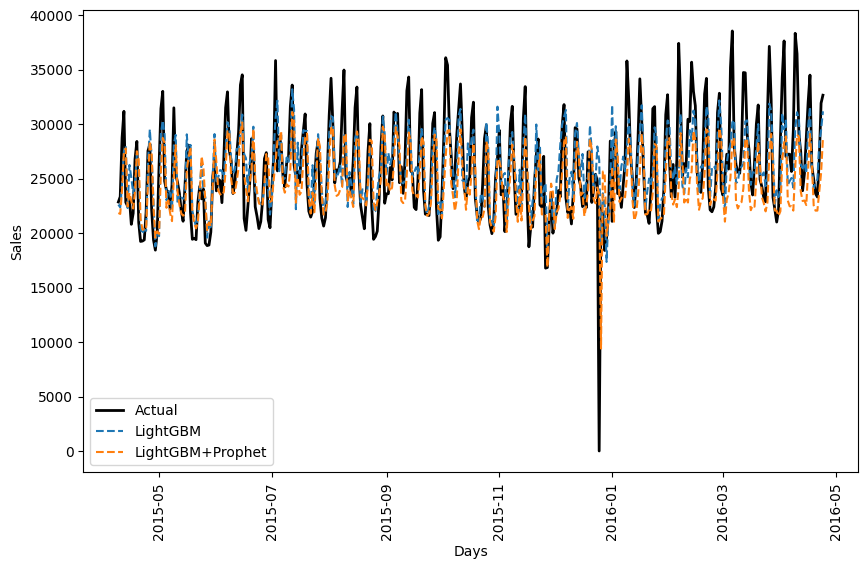

In [85]:
# Convert the index to a DatetimeIndex
test.index = pd.to_datetime(test.index)
plt.figure(figsize=(10, 6))

# Plot the actual and predicted values for the "FOODS" category
plt.plot(test['FOODS'], linewidth = 2, color ='black', label='Actual')
plt.plot(test_data.index, predictions_lgbm['FOODS'], '--',label='LightGBM')
plt.plot(test_data.index,prophet_lgbm_ensemble['FOODS'],'--',label='LightGBM+Prophet')

plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [88]:
#MAPE and RMSE calculations for ensembling method.
mape_ensemble = []
rmse_ensemble = []

for column in target_columns:
    actual = test[column].values.astype('float64')
    predicted_ensemble = prophet_lgbm_ensemble[column].values
    
    # Convert actual and predicted_ensemble to numpy arrays because actual is a dataframe and the other is not.
    actual = actual.flatten()
    predicted_ensemble = predicted_ensemble.flatten()
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(actual, predicted_ensemble)
    mape_ensemble.append(mape)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(actual, predicted_ensemble))
    rmse_ensemble.append(rmse)

print("RMSE_Ensemble:", rmse_ensemble)
print("MAPE_Ensemble:", mape_ensemble)

RMSE_Ensemble: [3903.7719091744016, 519.5933073273346, 1460.3508073469993, 483.7506057475894, 1047.733539413832, 2874.229848387095, 501.4032144487473, 90.4238885970287, 1197.589539083497, 286.228763880956, 2820.348623518936, 1439.313566672941, 2153.2572537138944, 704.0581955696836, 1618.5803150047554, 822.0731837423892, 284.08251371309683, 469.2986803042204, 572.7429731188919, 514.3214048077276, 663.8648454291134, 911.4689604251598, 794.2919623574052]
MAPE_Ensemble: [4.86532504497769, 4.3979670881956056e+16, 24.07955122469869, 8.4452604408742, 5.283997965266601e+16, 3.609294910290642, 3.892023017524073e+16, 5066474425129882.0, 8.715524046896475e+16, 4.855332290438401, 6.544323117051331, 6.923594741515039, 7.209145769986223, 4.986523508211621e+16, 3.732175510893986, 3.9034571841175083, 2.5753010512545524e+16, 8.335571738552513, 4.761724886885661e+16, 3.1870117926455968, 4.999871879518228, 10.396324497185612, 8.92567464539181]


###  RMSE Plot (including Ensembling)

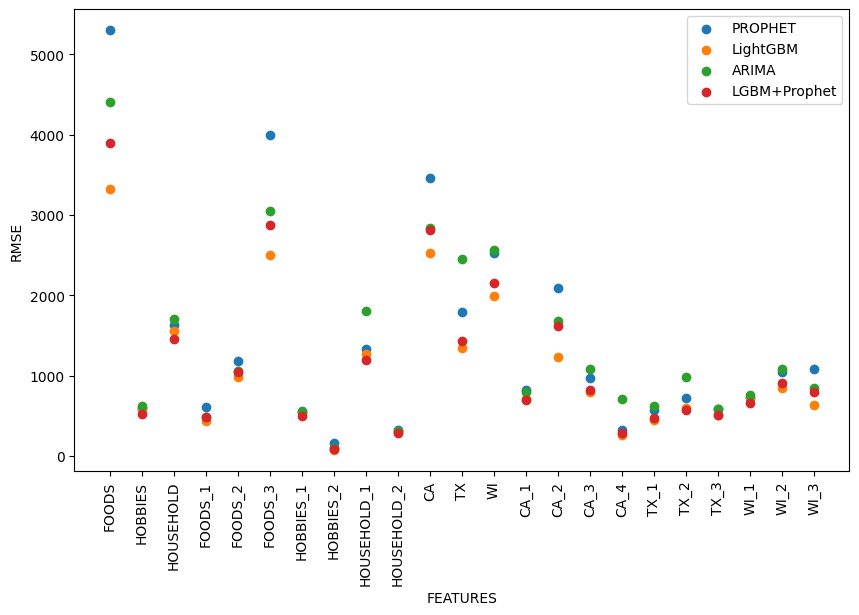

In [2]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3']

prophet_rmse = [5301.623329719902, 597.4043395495909, 1633.8766240582363, 608.0407142987697, 1188.3787984445187, 4000.841626437104, 562.1306982570026, 161.21043116892037, 1336.4195793128986, 323.5977981894443, 3459.4404039642304, 1790.5406370880542, 2526.2609502754617, 824.9772115486344, 2091.3778069266905, 969.4602774964568, 327.46010935947385, 569.8731930316046, 723.8847384406837, 585.7749971912388, 729.6913761833301, 1053.577187093273, 1086.7709855259027]
lgbm_rmse = [3323.572590710736, 584.9666530532597, 1556.9815601826692, 433.580811885487, 985.145058307548, 2506.319096949099, 546.4696275758293, 74.11445759725457,1270.9895115013646, 304.84942938691574, 2524.9280791791202, 1345.9826239889562, 1989.1700887986544, 711.5579674482576, 1228.992715257973, 795.5612385655091, 267.6572116193387, 452.17616746632797, 595.6935014294424, 508.4821113023423, 742.418801286614, 843.6342349679933, 632.6615970831949]
arima_rmse = [4414.427801036455, 625.0129703702443, 1708.9953500272914, 487.1101013596283, 1062.1228870227712, 3053.347541667216, 555.4494543218098, 107.7151437045555, 1805.211932364774, 314.772886635246, 2845.1658686836577, 2455.6378820617315, 2568.189448239621, 796.0200794610948, 1679.6588711859101, 1089.7251686454244, 714.4705377660863, 624.2840181834466, 983.8099082992557, 582.2712860138937, 765.2309697498303, 1090.065208980127, 853.7038134989234] 
lgbm_prophet_rmse = [3903.7719091744016, 519.5933073273346, 1460.3508073469993, 483.7506057475894, 1047.733539413832, 2874.229848387095, 501.4032144487473, 90.4238885970287, 1197.589539083497, 286.228763880956, 2820.348623518936, 1439.313566672941, 2153.2572537138944, 704.0581955696836, 1618.5803150047554, 822.0731837423892, 284.08251371309683, 469.2986803042204, 572.7429731188919, 514.3214048077276, 663.8648454291134, 911.4689604251598, 794.2919623574052]

plt.figure(figsize=(10, 6))
plt.scatter(target_cols, prophet_rmse, label="PROPHET")
plt.scatter(target_cols, lgbm_rmse, label="LightGBM")
plt.scatter(target_cols, arima_rmse, label="ARIMA")
plt.scatter(target_cols, lgbm_prophet_rmse, label="LGBM+Prophet")

plt.xlabel("FEATURES")
plt.ylabel("RMSE")
plt.legend()
plt.xticks(rotation=90)
plt.show()

### MAPE Plot (including Ensembling) 

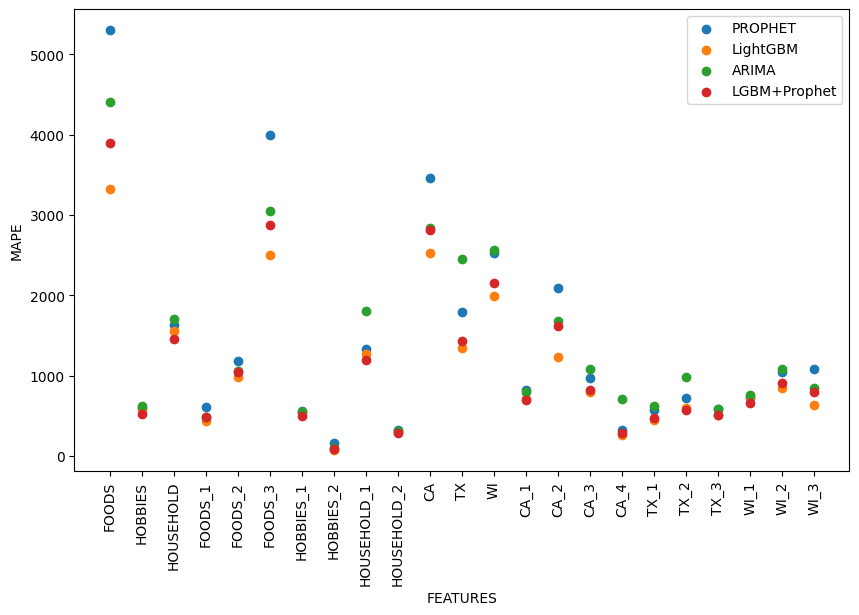

In [3]:
target_cols = ['FOODS','HOBBIES','HOUSEHOLD','FOODS_1','FOODS_2','FOODS_3','HOBBIES_1','HOBBIES_2','HOUSEHOLD_1',
               'HOUSEHOLD_2','CA', 'TX','WI','CA_1','CA_2', 'CA_3','CA_4', 'TX_1', 'TX_2', 'TX_3','WI_1','WI_2', 'WI_3'] 
prophet_mape = [4.2924385926396615, 4.3668410261305784e+16, 20.811984825352617, 8.016773481374887, 4.864900488117681e+16, 3.057471387046034, 3.710896775023157e+16, 6150141164100668.0, 7.421872919005626e+16, 4.331195138915735, 5.649445254110273, 6.1533256942561145, 6.47695216426565, 4.5481428789541704e+16, 2.425962623395828, 3.493233994656482, 2.3840233321259836e+16, 7.472485534277767, 3.70919010331124e+16, 3.0198442640152927, 4.896939838162112, 10.061242287010963, 6.507056662836419]
lgbm_mape = [0.09103209396153308,0.11834419501970976, 0.12334029634086478, 0.10585752692541775, 0.1526492489023425, 0.10068463661244745, 0.1250662873532851,0.15851564777142907,0.12784034943337377, 0.12220433124696857, 0.10660274724359552, 0.0856975029548464, 0.13205575167781078,0.11893808321323282, 0.29872346641541914, 0.09078957270617109, 0.07827491405723837, 0.09900575265306356, 0.10417071978561113, 0.10206807502411998, 0.16312508129842623, 0.14963717949499108, 0.13737085799497573]
arima_mape = [4.552398391956181, 4.909902140005632e+16, 21.267312736323365, 8.06251557292648, 5.223556724520484e+16, 3.6430120788858784, 4.140351401850404e+16, 4706108864513807.0, 1.0229238476963355e+17, 5.02294043021412, 6.609414302589637, 8.242927970195646, 6.970185839792852, 4.7063467144308776e+16, 3.1274917598288345, 4.321603542453432, 3.650373034238475e+16, 8.782219074654996, 5.588247325798659e+16, 3.3427401181554357, 4.313065951889741, 10.278232893904914, 8.21972392522621]
lgbm_prophet_mape = [4.86532504497769, 4.3979670881956056e+16, 24.07955122469869, 8.4452604408742, 5.283997965266601e+16, 3.609294910290642, 3.892023017524073e+16, 5066474425129882.0, 8.715524046896475e+16, 4.855332290438401, 6.544323117051331, 6.923594741515039, 7.209145769986223, 4.986523508211621e+16, 3.732175510893986, 3.9034571841175083, 2.5753010512545524e+16, 8.335571738552513, 4.761724886885661e+16, 3.1870117926455968, 4.999871879518228, 10.396324497185612, 8.92567464539181]

plt.figure(figsize=(10, 6))
plt.scatter(target_cols, prophet_rmse, label="PROPHET")
plt.scatter(target_cols, lgbm_rmse, label="LightGBM")
plt.scatter(target_cols, arima_rmse, label="ARIMA")
plt.scatter(target_cols, lgbm_prophet_rmse, label="LGBM+Prophet")

plt.xlabel("FEATURES")
plt.ylabel("MAPE")
plt.legend()
plt.xticks(rotation=90)
plt.show()